In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import textstat
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler,LabelEncoder



# Load the training data
training_data = pd.read_excel('data/training_set_rel3.xls')
test_data = pd.read_excel('data/valid_set.xls')

In [2]:
training_data

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,NaN,9.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,NaN,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,NaN,10.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12973,21626,8,In most stories mothers and daughters are eit...,17.0,18.0,NaN,35.0,NaN,NaN,NaN,...,4.0,4.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
12974,21628,8,I never understood the meaning laughter is th...,15.0,17.0,NaN,32.0,NaN,NaN,NaN,...,4.0,4.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
12975,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",20.0,26.0,40.0,40.0,NaN,NaN,NaN,...,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0
12976,21630,8,Trippin' on fen...,20.0,20.0,NaN,40.0,NaN,NaN,NaN,...,4.0,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
test_data

,essay_id,essay_set,essay,domain1_predictionid,domain2_predictionid
0,1788,1,"Dear @ORGANIZATION1, @CAPS1 more and more peop...",1788,NaN
1,1789,1,Dear @LOCATION1 Time @CAPS1 me tell you what I...,1789,NaN
2,1790,1,"Dear Local newspaper, Have you been spending a...",1790,NaN
3,1791,1,"Dear Readers, @CAPS1 you imagine how life woul...",1791,NaN
4,1792,1,"Dear newspaper, I strongly believe that comput...",1792,NaN
...,...,...,...,...,...
4213,21933,8,Have you ever noticed that if two little kids...,24933,NaN
4214,21934,8,Laughter @CAPS1 I ...,24934,NaN
4215,21935,8,Laughter in @CAPS1 A laugh is not just an act...,24935,NaN
4216,21937,8,LAUGHTER @CAPS1 i was younger my friend live...,24937,NaN


In [6]:
simplified_df = training_data[['essay_id', 'essay_set', 'essay','domain1_score','domain2_score']]

In [3]:
test = simplified_df["essay"][4050]

In [7]:
X = simplified_df['essay']
y = simplified_df['essay_set']

# Encodage des labels si nécessaire
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Transformation des textes en vecteurs TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=50)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [8]:
from sklearn.utils.class_weight import compute_sample_weight

# Calcul des poids des échantillons pour gérer le déséquilibre
sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)

# Création des objets DMatrix pour XGBoost
dtrain = xgb.DMatrix(X_train_tfidf, label=y_train, weight=sample_weight)
dtest = xgb.DMatrix(X_test_tfidf, label=y_test)

# Configuration des paramètres du modèle
params = {
    'objective': 'multi:softprob',  # Utilisation de softprob pour la classification multi-classe
    'num_class': len(np.unique(y_encoded)),  # Nombre de classes
    'max_depth': 6,  # Profondeur maximale de chaque arbre
    'learning_rate': 0.1,  # Taux d'apprentissage
    'subsample': 0.8,  # Fraction des échantillons à utiliser pour chaque arbre (pour éviter le surajustement)
    'colsample_bytree': 0.8,  # Fraction des caractéristiques à utiliser pour chaque arbre
}

# Entraînement du modèle
model = xgb.train(params, dtrain, num_boost_round=100)

# Prédiction et évaluation
predictions = model.predict(dtest)
predictions = np.argmax(predictions, axis=1)

# Calcul de l'exactitude (vous pouvez également calculer d'autres métriques selon vos besoins)
accuracy = np.sum(predictions == y_test) / y_test.shape[0]
print(f'Accuracy: {accuracy}')

Accuracy: 0.9087057010785824


Accuracy: 0.9208155523944997
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       589
           2       0.94      0.94      0.94       600
           3       0.84      0.86      0.85       568
           4       0.93      0.93      0.93       586
           5       0.89      0.88      0.88       601
           6       0.96      0.95      0.96       600
           7       0.89      0.90      0.90       441
           8       0.91      0.88      0.89       233

    accuracy                           0.92      4218
   macro avg       0.92      0.92      0.92      4218
weighted avg       0.92      0.92      0.92      4218



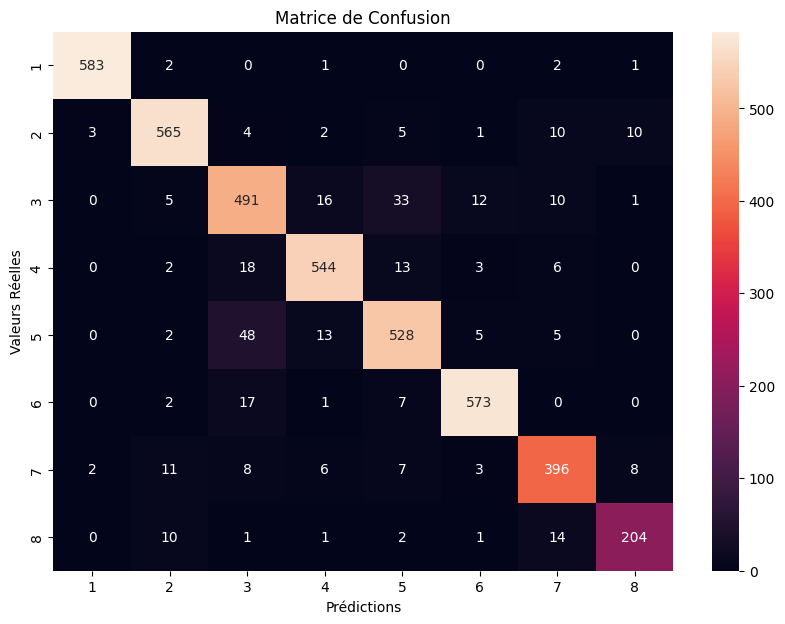

In [9]:

new_X_tfidf = tfidf_vectorizer.transform(test_data['essay'])
new_dmatrix = xgb.DMatrix(new_X_tfidf)
new_predictions = model.predict(new_dmatrix)
new_predicted_classes = np.argmax(new_predictions, axis=1)
new_predicted_labels = label_encoder.inverse_transform(new_predicted_classes)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Calcul de l'exactitude
accuracy = accuracy_score(test_data['essay_set'], new_predicted_labels)
print(f'Accuracy: {accuracy}')

# Affichage du rapport de classification
print(classification_report(test_data['essay_set'], new_predicted_labels))

# Affichage de la matrice de confusion
conf_matrix = confusion_matrix(test_data['essay_set'], new_predicted_labels, labels=label_encoder.classes_)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.show()

# topic modeling => confusion matrix

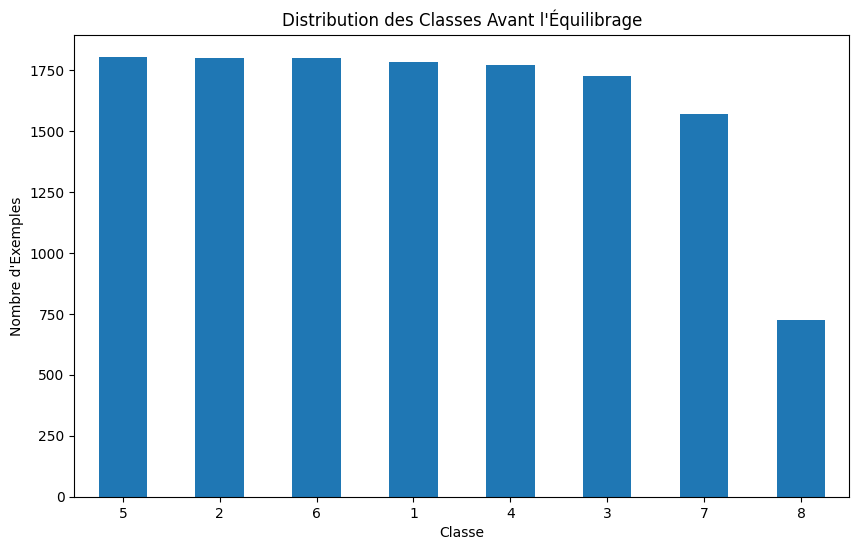

In [9]:
import matplotlib.pyplot as plt

# Distribution des classes avant l'équilibrage
plt.figure(figsize=(10, 6))
simplified_df['essay_set'].value_counts().plot(kind='bar')
plt.title('Distribution des Classes Avant l\'Équilibrage')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'Exemples')
plt.xticks(rotation=0)
plt.show()


In [54]:
# Faire des prédictions
y_pred = np.argmax(model.predict(dtest), axis=1)
# Création d'un DataFrame avec les vraies classes et les prédictions
results_df = pd.DataFrame({'True_Class': y_test, 'Predicted_Class': y_pred})

# Encoder les classes prédites en arrière vers les labels originaux si nécessaire
results_df['True_Class'] = label_encoder.inverse_transform(results_df['True_Class'])
results_df['Predicted_Class'] = label_encoder.inverse_transform(results_df['Predicted_Class'])


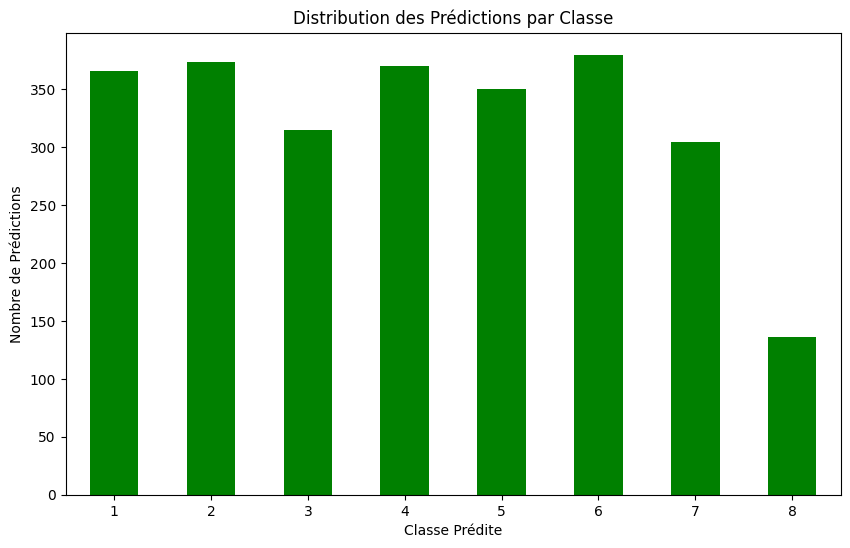

In [55]:
# Distribution des prédictions
plt.figure(figsize=(10, 6))
results_df['Predicted_Class'].value_counts().sort_index().plot(kind='bar', color='green')
plt.title('Distribution des Prédictions par Classe')
plt.xlabel('Classe Prédite')
plt.ylabel('Nombre de Prédictions')
plt.xticks(rotation=0)
plt.show()


In [44]:
#test = "Hello my name is Jordan"
test_1 = tfidf_vectorizer.transform([test])
test_2 = xgb.DMatrix(test_1)

pred = np.argmax(model.predict(test_2),axis=1)

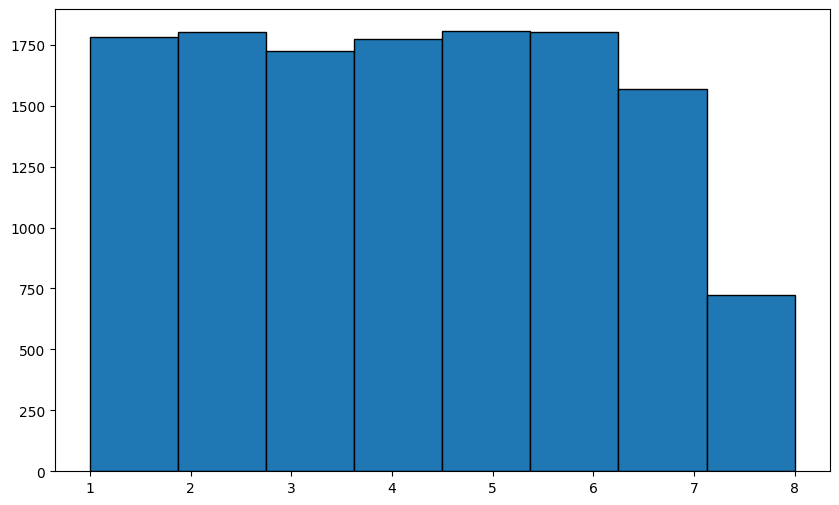

In [18]:
plt.figure(figsize=(10, 6))
plt.hist(simplified_df['essay_set'], bins=8, edgecolor='black')
plt.show()

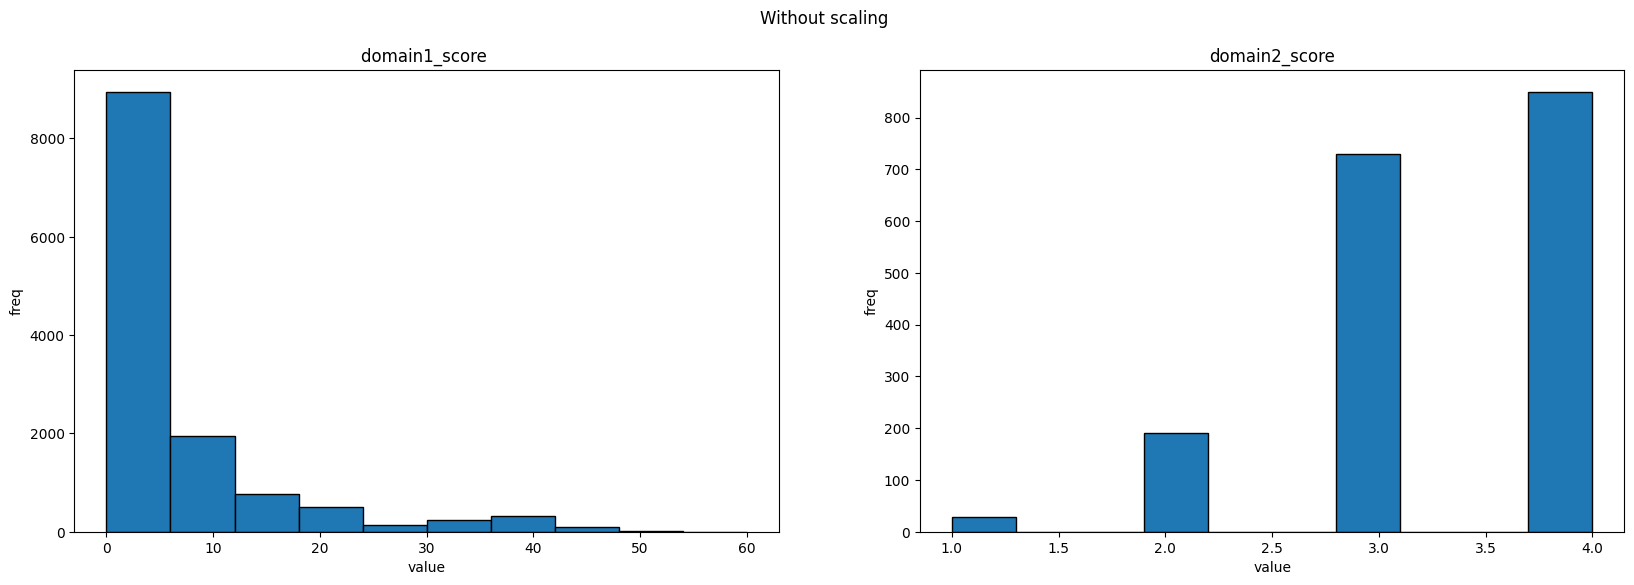

In [3]:
plt.figure(figsize=(20, 6))
plt.suptitle("Without scaling")

plt.subplot(1, 2, 1)
plt.hist(simplified_df['domain1_score'], edgecolor='black')
plt.title('domain1_score ')
plt.xlabel('value')
plt.ylabel('freq')

plt.subplot(1, 2, 2)
plt.hist(simplified_df['domain2_score'], edgecolor='black')
plt.title('domain2_score')
plt.xlabel('value')
plt.ylabel('freq')

plt.show()

In [16]:
scaler = MinMaxScaler(feature_range=(-1,1))
raw_scaling_domain1_score = np.array(simplified_df["domain1_score"]).reshape(-1,1)
scaler.fit(raw_scaling_domain1_score)
simplified_df["raw_scaled_domain1_score"] = scaler.transform(raw_scaling_domain1_score)

C:\Users\jorda\AppData\Local\Temp\ipykernel_7856\1447933149.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simplified_df["raw_scaled_domain1_score"] = scaler.transform(raw_scaling_domain1_score)


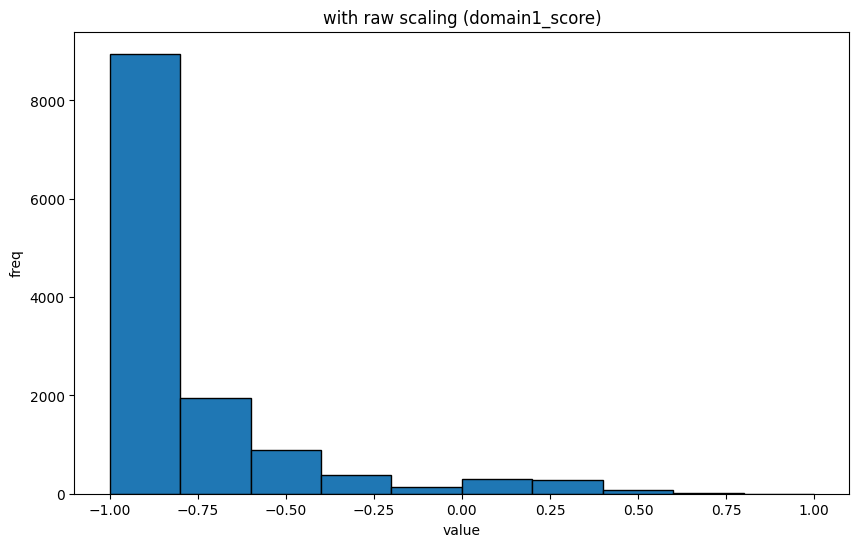

In [17]:
plt.figure(figsize=(10, 6))
plt.title("with raw scaling (domain1_score)")
plt.hist(simplified_df['raw_scaled_domain1_score'], bins=10, edgecolor='black')
plt.xlabel('value')
plt.ylabel('freq')
plt.show()

In [18]:
# domain_score1
scaled_domain1_score_list = []
for i in np.arange(8):
    df_temp = simplified_df[simplified_df["essay_set"]==i+1].copy() # parsing essay set
    domain_score = np.array(df_temp["domain1_score"]).reshape(-1,1) # turning score column in array
    scaler = MinMaxScaler(feature_range=(-1,1)) # scaler
    scaler.fit(domain_score) # fitting ...
    df_temp["scaled_domain1_score"] = scaler.transform(domain_score) # scaling the score column
    scaled_domain1_score_list.append(df_temp["scaled_domain1_score"]) # add the scaled column to lists

simplified_df["scaled_domain1_score"] = pd.concat(scaled_domain1_score_list) # concatenate to add all essay set columns

# domain_score2
scaler2 = MinMaxScaler(feature_range=(-1,1))
x = np.array(simplified_df["domain2_score"]).reshape(-1,1)
scaler2.fit(x)
simplified_df["scaled_domain2_score"] = scaler2.transform(x)

C:\Users\jorda\AppData\Local\Temp\ipykernel_7856\704446160.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simplified_df["scaled_domain1_score"] = pd.concat(scaled_domain1_score_list) # concatenate to add all essay set columns
C:\Users\jorda\AppData\Local\Temp\ipykernel_7856\704446160.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simplified_df["scaled_domain2_score"] = scaler2.transform(x)


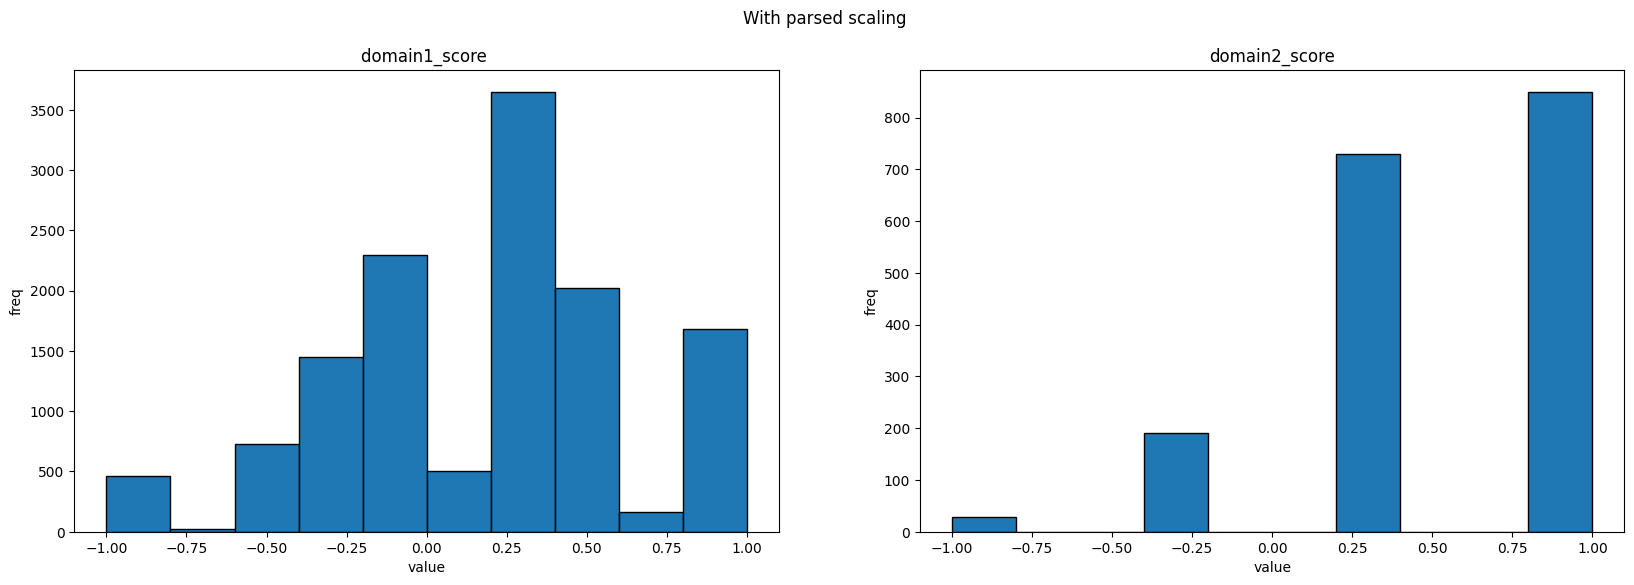

In [19]:
plt.figure(figsize=(20, 6))
plt.suptitle("With parsed scaling")

plt.subplot(1, 2, 1)
plt.hist(simplified_df['scaled_domain1_score'], edgecolor='black')
plt.title('domain1_score ')
plt.xlabel('value')
plt.ylabel('freq')

plt.subplot(1, 2, 2)
plt.hist(simplified_df['scaled_domain2_score'], edgecolor='black')
plt.title('domain2_score')
plt.xlabel('value')
plt.ylabel('freq')

plt.show()

In [21]:
# first row for each set
scaled_df = simplified_df[["essay_id","essay_set","essay","scaled_domain1_score","scaled_domain2_score"]]

In [9]:
def example_for_each_set(df,cut=30):
    displayed_df = pd.DataFrame()
    for i in np.arange(8):
        df_temp = df[df["essay_set"]==i+1].copy()

        displayed_df = pd.concat([displayed_df,df_temp.iloc[[0]]])

    displayed_df["essay"] = displayed_df["essay"].apply(lambda x: x[:cut])
    display(displayed_df)

example_for_each_set(scaled_df)

,essay_id,essay_set,essay,scaled_domain1_score,scaled_domain2_score
0,1,1,"Dear local newspaper, I think",0.200000,NaN
1783,2978,2,Certain materials being remove,0.200000,1.0
3583,5978,3,The features of the setting af,-0.333333,NaN
5309,8863,4,The author concludes the story,-1.000000,NaN
7081,11827,5,In this memoir of Narciso Rodr,0.000000,NaN
8886,14834,6,There were many obstacles that,0.000000,NaN
10686,17834,7,Patience is when your waiting,0.181818,NaN
12255,20716,8,A long time ago when I was in,-0.040000,NaN


In [10]:
def calculate_flesch_reading_ease(text):
    return textstat.flesch_reading_ease(text)

def calculate_gunning_fog(text):
    return textstat.gunning_fog(text)

def calculate_ari(text):
    return textstat.automated_readability_index(text)

def calculate_smog_index(text):
    return textstat.smog_index(text)

def calculate_flesch_kincaid_grade(text):
    return textstat.flesch_kincaid_grade(text)

def calculate_coleman_liau_index(text):
    return textstat.coleman_liau_index(text)

def calculate_dale_chall(text):
    return textstat.dale_chall_readability_score(text)

# Appliquer ces fonctions à la colonne 'essay'
scaled_df['flesch_reading_ease'] = scaled_df['essay'].copy().apply(calculate_flesch_reading_ease)

scaled_df['gunning_fog'] = scaled_df['essay'].copy().apply(calculate_gunning_fog)
scaled_df['ari'] = scaled_df['essay'].copy().apply(calculate_ari)
scaled_df['smog_index'] = scaled_df['essay'].copy().apply(calculate_smog_index)
scaled_df['flesch_kincaid_grade'] = scaled_df['essay'].copy().apply(calculate_flesch_kincaid_grade)
scaled_df['coleman_liau_index'] = scaled_df['essay'].copy().apply(calculate_coleman_liau_index)
scaled_df['dale_chall'] = scaled_df['essay'].copy().apply(calculate_dale_chall)

C:\Users\jorda\AppData\Local\Temp\ipykernel_9352\3249739945.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df['flesch_reading_ease'] = scaled_df['essay'].copy().apply(calculate_flesch_reading_ease)
C:\Users\jorda\AppData\Local\Temp\ipykernel_9352\3249739945.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df['gunning_fog'] = scaled_df['essay'].copy().apply(calculate_gunning_fog)


In [20]:
scaled_df   

NameError: name 'scaled_df' is not defined

In [11]:
example_for_each_set(scaled_df,cut=5)

,essay_id,essay_set,essay,scaled_domain1_score,scaled_domain2_score,flesch_reading_ease,gunning_fog,ari,smog_index,flesch_kincaid_grade,coleman_liau_index,dale_chall
0,1,1,Dear,0.200000,NaN,74.02,10.31,11.3,10.2,8.5,8.54,7.00
1783,2978,2,Certa,0.200000,1.0,72.70,10.19,11.7,9.5,9.0,8.36,6.58
3583,5978,3,The f,-0.333333,NaN,71.14,8.37,6.7,7.8,7.6,6.20,7.58
5309,8863,4,The a,-1.000000,NaN,69.41,8.91,8.8,10.5,8.2,7.89,6.82
7081,11827,5,In th,0.000000,NaN,77.67,9.38,10.0,9.2,7.1,8.36,8.04
8886,14834,6,There,0.000000,NaN,59.33,10.74,10.9,11.5,10.0,9.40,8.01
10686,17834,7,Patie,0.181818,NaN,88.53,3.28,3.5,4.9,2.9,5.24,5.97
12255,20716,8,A lo,-0.040000,NaN,88.87,6.90,6.1,7.0,4.9,5.10,5.87
